**Install requirements**

In [ ]:

!pip3 install 'torch==1.4.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'


**Import libraries**

In [1]:
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.backends import cudnn
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
from torchvision.models import alexnet
from tqdm import tqdm
%matplotlib inline

ImportError: DLL load failed: Impossibile trovare il modulo specificato.

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 3e-5          # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 15      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

BASE_FILE_PATH = "DA_RUN18_LR3e-5_ADAMW_EP15_SS15_G01_ALL_TRANSF"


**Define Data Preprocessing**

In [2]:
# Define transforms for training phase
"""train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])"""

train_transform = transforms.Compose([
                                      transforms.RandomApply([transforms.ColorJitter()], p=0.3),
                                      transforms.RandomApply([transforms.Grayscale(3)], p=0.3),
                                      transforms.RandomChoice([
                                                               transforms.RandomHorizontalFlip(p=.5),
                                                               transforms.RandomRotation(45)
                                                               ]),
                                      transforms.Resize(256),
                                      transforms.RandomCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

NameError: name 'transforms' is not defined

**Prepare Dataset**

In [3]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/lore-lml/Caltech101-ML-HW2.git
  !mv 'Caltech101-ML-HW2' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech
import numpy as np

# Prepare Pytorch train/test Datasets
trainVal_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

"""train_len = int(train_dataset.__len__() / 2)
val_len = train_dataset.__len__() - train_len
train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])"""

y_true = trainVal_dataset.get_labels()
train_idx, val_idx = trainVal_dataset.get_train_val_idxs()

train_dataset = Subset(trainVal_dataset, train_idx)
val_dataset = Subset(trainVal_dataset, val_idx)

# Check dataset sizes
print(f"# classes train_set: {len(set(y_true[train_idx]))}")
print(f"# classes val_set: {len(set(y_true[val_idx]))}")
print(f"# classes test_set: {len(set(test_dataset.get_labels()))}")
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))


ImportError: DLL load failed: Impossibile trovare il modulo specificato.

**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [ ]:
def get_Alexnet(pretrained=False):
  net = alexnet(pretrained=pretrained)
  # AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
  # We need 101 outputs for Caltech-101
  # nn.Linear in pytorch is a fully connected layer
  # The convolutional layer is nn.Conv2d
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
  return net

net = get_Alexnet(pretrained=True) # Loading AlexNet model

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [ ]:
def init_cnn_objects(model):
  
  # Define loss function
  criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

  # Choose parameters to optimize
  # To access a different set of parameters, you have to access submodules of AlexNet
  # (nn.Module objects, like AlexNet, implement the Composite Pattern)
  # e.g.: parameters of the fully connected layers: net.classifier.parameters()
  # e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
  parameters_to_optimize = model.parameters() # In this case we optimize over all the parameters of AlexNet

  # Define optimizer
  # An optimizer updates the weights based on loss
  # We use SGD with momentum
  #optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  #optimizer = optim.Adam(parameters_to_optimize, lr=LR,amsgrad=True)
  optimizer = optim.AdamW(parameters_to_optimize, lr=LR,amsgrad=True, weight_decay=WEIGHT_DECAY)

  # Define scheduler
  # A scheduler dynamically changes learning rate
  # The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  return criterion, optimizer, scheduler

criterion, optimizer, scheduler = init_cnn_objects(net)

In [ ]:
def evaluate(data_loader, model, is_validation=False):
  model.train(False) # Set Network to evaluation mode
  losses = []
  cumulative_loss = .0
  running_corrects = 0
  for images, labels in tqdm(data_loader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = model(images)

    # Loss
    if is_validation:
      loss = criterion(outputs, labels)
      cumulative_loss += loss.item()

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))

  print('Validation Accuracy: {}'.format(accuracy))
  
  return accuracy, cumulative_loss / len(data_loader)

def train_model(model, base_file_path=BASE_FILE_PATH):
  # List to store every loss of each step.
  train_losses = []
  val_losses = []
  accuracies = []
  loss_min = -1
  # By default, everything is loaded to cpu
  model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    cumulative_loss = .0
    # Iterate over the dataset
    for images, labels in train_dataloader:
    
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      model.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = model(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)
      cumulative_loss += loss.item()

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss_train {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1

    # Evaluate Validation set and get accuracy and losses for the current epoch
    curr_accuracy, curr_val_loss = evaluate(val_dataloader, model, is_validation=True)
    print('Loss_val {}'.format(curr_val_loss))
    # Avg of cumulative loss
    train_losses.append(cumulative_loss / len(train_dataloader))
    val_losses.append(curr_val_loss)
    accuracies.append(curr_accuracy)
    # If the loss reached a lower value than before, save model state
    if loss_min == -1 or loss_min > curr_val_loss:
      loss_min = curr_val_loss
      torch.save(model, f"{base_file_path}_best_model.pth")
    # Step the scheduler
    scheduler.step() 

  print("\n************ END OF TRAINING ***************")
  return train_losses, val_losses, accuracies

**Train**

In [ ]:
train_losses_scratch, val_losses_scratch, accuracies_scratch = train_model(net, BASE_FILE_PATH)

Starting epoch 1/15, LR = [3e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss_train 4.8609395027160645


  0%|          | 0/12 [00:00<?, ?it/s]

Step 10, Loss_train 4.020678520202637


100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


Validation Accuracy: 0.25380359612724757
Loss_val 3.8391027450561523
Starting epoch 2/15, LR = [3e-05]
Step 20, Loss_train 3.2942986488342285


100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


Validation Accuracy: 0.3070539419087137
Loss_val 3.1101698676745095
Starting epoch 3/15, LR = [3e-05]
Step 30, Loss_train 2.600191831588745


100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


Validation Accuracy: 0.42704011065006914
Loss_val 2.608141839504242
Starting epoch 4/15, LR = [3e-05]
Step 40, Loss_train 2.1953530311584473


100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


Validation Accuracy: 0.5110650069156293
Loss_val 2.112651507059733
Starting epoch 5/15, LR = [3e-05]
Step 50, Loss_train 1.78926420211792


100%|██████████| 12/12 [00:10<00:00,  1.15it/s]


Validation Accuracy: 0.5791839557399724
Loss_val 1.7256509562333424
Starting epoch 6/15, LR = [3e-05]
Step 60, Loss_train 1.4208937883377075


100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


Validation Accuracy: 0.6431535269709544
Loss_val 1.4703241089979808
Starting epoch 7/15, LR = [3e-05]
Step 70, Loss_train 1.1461986303329468


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Validation Accuracy: 0.6663208852005532
Loss_val 1.3254832128683727
Starting epoch 8/15, LR = [3e-05]
Step 80, Loss_train 1.0939322710037231


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Validation Accuracy: 0.6825726141078838
Loss_val 1.2242232660452526
Starting epoch 9/15, LR = [3e-05]
Step 90, Loss_train 0.9736042022705078


100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


Validation Accuracy: 0.6946749654218534
Loss_val 1.1732828319072723
Starting epoch 10/15, LR = [3e-05]
Step 100, Loss_train 0.7793921232223511


100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


Validation Accuracy: 0.7123098201936376
Loss_val 1.1153992265462875
Starting epoch 11/15, LR = [3e-05]
Step 110, Loss_train 0.6895582675933838


  0%|          | 0/12 [00:00<?, ?it/s]

Step 120, Loss_train 0.6327847242355347


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Validation Accuracy: 0.7278699861687413
Loss_val 1.0550772349039714
Starting epoch 12/15, LR = [3e-05]
Step 130, Loss_train 0.6561768651008606


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Validation Accuracy: 0.7375518672199171
Loss_val 1.0409518678983052
Starting epoch 13/15, LR = [3e-05]
Step 140, Loss_train 0.5575341582298279


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Validation Accuracy: 0.7403181189488244
Loss_val 1.0091201762358348
Starting epoch 14/15, LR = [3e-05]
Step 150, Loss_train 0.576063871383667


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Validation Accuracy: 0.7482710926694329
Loss_val 0.9810458372036616
Starting epoch 15/15, LR = [3e-05]
Step 160, Loss_train 0.33688294887542725


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Validation Accuracy: 0.7503457814661134
Loss_val 0.9804651985565821

************ END OF TRAINING ***************


In [ ]:
def save_results(file_name, train_losses, val_losses, accuracies):
  with open(file_name, "w", encoding="utf-8") as f:
    f.write("train_loss,val_loss,accuracy\n")
    for tl,vl,accuracy in zip(train_losses, val_losses, accuracies):
      f.write(f"{tl},{vl},{accuracy}\n")

save_results(f"{BASE_FILE_PATH}_data.csv", train_losses_scratch, val_losses_scratch, accuracies_scratch)
print("*************** DATA SAVED *************")

*************** DATA SAVED *************


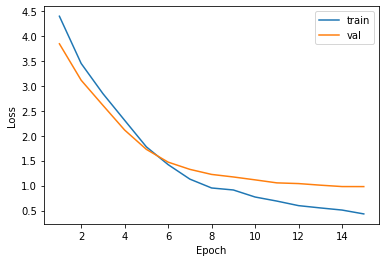

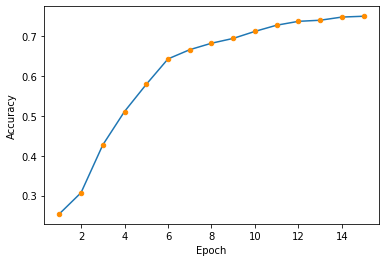

In [ ]:

epochs = np.arange(1, NUM_EPOCHS+1)
plt.figure()
# plt.scatter(epochs, train_losses, c="darkorange", s=20)
plt.plot(epochs, train_losses_scratch, label="train")
plt.plot(epochs, val_losses_scratch, label="val")
plt.legend(loc="upper right")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure()
plt.scatter(epochs, accuracies_scratch, c="darkorange", s=20)
plt.plot(epochs, accuracies_scratch, zorder=-1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

**Test**

In [ ]:
best_model = torch.load(f"{BASE_FILE_PATH}_best_model.pth").to(DEVICE)
best_model.eval()
accuracy,_ = evaluate(test_dataloader, best_model, is_validation=False)

with open(f"{BASE_FILE_PATH}_final_result.txt", "w", encoding="utf-8") as f:
  f.write("*************** TRAINING FROM SCRATCH ***************\n")
  f.write(f"LR = {LR}\nAccuracy on test = {accuracy}\nLoss_min = {min(val_losses_scratch)}\n\n")


100%|██████████| 12/12 [00:11<00:00,  1.07it/s]

Validation Accuracy: 0.8042876901798064


# Using best model, and freeze layers

In [ ]:
def is_layers_unfreezed(model):
  for param in model.parameters():
    print(param.requires_grad)

In [ ]:
net_only_full = get_Alexnet(True)
# Freeze Conv Layers
conv_layers = net_only_full.features.parameters()

for par in conv_layers:
  par.requires_grad = False

criterion, optimizer, scheduler = init_cnn_objects(net_only_full)
is_layers_unfreezed(net_only_full)
path = f"{BASE_FILE_PATH}_only_full"


False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


Starting epoch 1/15, LR = [3e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss_train 4.768636703491211


  0%|          | 0/12 [00:00<?, ?it/s]

Step 10, Loss_train 3.9220221042633057


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Validation Accuracy: 0.25864453665283543
Loss_val 3.8173309167226157
Starting epoch 2/15, LR = [3e-05]
Step 20, Loss_train 3.327472448348999


100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


Validation Accuracy: 0.30567081604426005
Loss_val 3.1621376077334085
Starting epoch 3/15, LR = [3e-05]
Step 30, Loss_train 2.834895372390747


100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


Validation Accuracy: 0.39107883817427386
Loss_val 2.732784390449524
Starting epoch 4/15, LR = [3e-05]
Step 40, Loss_train 2.5588653087615967


100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


Validation Accuracy: 0.48858921161825725
Loss_val 2.367352604866028
Starting epoch 5/15, LR = [3e-05]
Step 50, Loss_train 2.168797254562378


100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


Validation Accuracy: 0.5397648686030428
Loss_val 2.0452783604462943
Starting epoch 6/15, LR = [3e-05]
Step 60, Loss_train 1.7151020765304565


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]


Validation Accuracy: 0.5954356846473029
Loss_val 1.7604862749576569
Starting epoch 7/15, LR = [3e-05]
Step 70, Loss_train 1.6055642366409302


100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


Validation Accuracy: 0.6434993084370678
Loss_val 1.5137275954087575
Starting epoch 8/15, LR = [3e-05]
Step 80, Loss_train 1.1230287551879883


100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Validation Accuracy: 0.6829183955739973
Loss_val 1.3347110946973164
Starting epoch 9/15, LR = [3e-05]
Step 90, Loss_train 1.2341071367263794


100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


Validation Accuracy: 0.686030428769018
Loss_val 1.2071138322353363
Starting epoch 10/15, LR = [3e-05]
Step 100, Loss_train 0.9625970721244812


100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


Validation Accuracy: 0.7043568464730291
Loss_val 1.1213440050681431
Starting epoch 11/15, LR = [3e-05]
Step 110, Loss_train 0.7411473989486694


  0%|          | 0/12 [00:00<?, ?it/s]

Step 120, Loss_train 0.8011756539344788


100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Validation Accuracy: 0.7195712309820194
Loss_val 1.0759529421726863
Starting epoch 12/15, LR = [3e-05]
Step 130, Loss_train 0.7341960668563843


100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Validation Accuracy: 0.7268326417704011
Loss_val 1.040119965871175
Starting epoch 13/15, LR = [3e-05]
Step 140, Loss_train 0.6724228262901306


100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


Validation Accuracy: 0.7392807745504841
Loss_val 1.0123058954874675
Starting epoch 14/15, LR = [3e-05]
Step 150, Loss_train 0.6226800680160522


100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


Validation Accuracy: 0.7475795297372061
Loss_val 0.9608256965875626
Starting epoch 15/15, LR = [3e-05]
Step 160, Loss_train 0.583574652671814


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Validation Accuracy: 0.7479253112033195
Loss_val 0.958409383893013

************ END OF TRAINING ***************


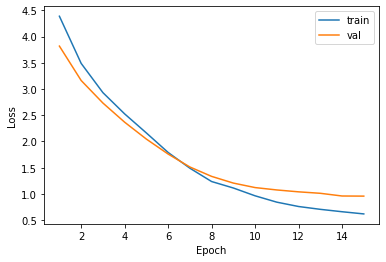

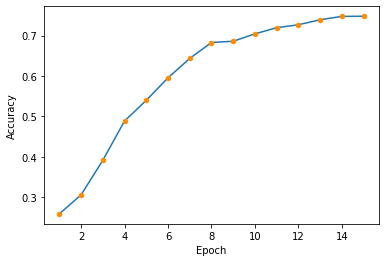

In [ ]:
train_losses_only_full, val_losses_only_full, accuracies_only_full = train_model(net_only_full, path)

epochs = np.arange(1, NUM_EPOCHS+1)
plt.figure()
plt.plot(epochs, train_losses_only_full, label="train")
plt.plot(epochs, val_losses_only_full, label="val")
plt.legend(loc="upper right")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure()
plt.scatter(epochs, accuracies_only_full, c="darkorange", s=20)
plt.plot(epochs, accuracies_only_full, zorder=-1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
save_results(f"{path}_data.csv", train_losses_only_full, val_losses_only_full, accuracies_only_full)
print("*************** DATA SAVED *************")

*************** DATA SAVED *************


In [ ]:
best_model_only_full = torch.load(f"{path}_best_model.pth").to(DEVICE)
best_model_only_full.eval()
accuracy,_ = evaluate(test_dataloader, best_model_only_full, is_validation=False)

with open(f"{BASE_FILE_PATH}_final_result.txt", "a", encoding="utf-8") as f:
  f.write("*************** TRAINING ONLY FULL ***************\n")
  f.write(f"LR = {LR}\nAccuracy on test = {accuracy}\nLoss_min = {min(val_losses_only_full)}\n\n")

100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

Validation Accuracy: 0.8195020746887967


# Graph losses and accuracies over unfreezed and only_full nets

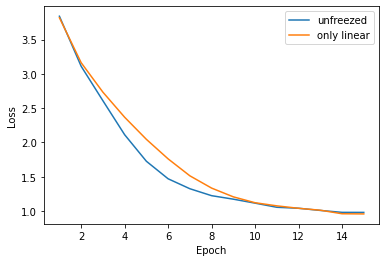

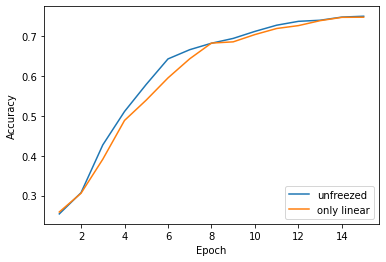

In [ ]:
epochs = np.arange(1, NUM_EPOCHS+1)
plt.figure()
plt.plot(epochs, val_losses_scratch, label="unfreezed")
plt.plot(epochs, val_losses_only_full, label="only linear")
#plt.plot(epochs, val_losses_only_conv, label="only conv")
plt.legend(loc="upper right")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochs, accuracies_scratch, label="unfreezed")
plt.plot(epochs, accuracies_only_full, label="only linear")
#plt.plot(epochs, accuracies_only_conv, label="only conv")
plt.legend(loc="lower right")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()